<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/Parciales/AyudaParcial1TAM_20241.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genere una simulacion sobre Python de los regresores por maxima verosimilitud y maximo a-posteriori, discutidos en el punto 2.1:

Genere una simulación sobre Python de los regresores por máxima verosimilitud y máximo a-posteriori, discutidos en el punto 2.1, para ajustar la señal: ${t}_n = \cos\left[\frac{x_n}{3}\right] + \cos\left[\frac{x_n}{4}\right] + \eta_n,$ con $x_n \in [0, 24\pi]$, contaminada con ruido blanco Gaussiano $\eta_n ( \text{SNRdB} = 2 [dB])$. Asuma mapeo $ \phi(\cdot)$ del tipo polinomial de orden $ Q$ y prior $p(w) = \mathcal{N}(w|0, \sigma^2_w)$. Simule 500 datos para entrenar los modelos y 200 para predecir. Incluya normalización por MinMaxScaler() de sklearn después de generar el mapeo no lineal.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Señal verdadera: $t_n = \cos\left(\frac{x_n}{3}\right) + \cos\left(\frac{x_n}{4}\right)$

In [2]:
#gerando los datos de entrada de la función dada
N = 700 #Datos totales
SNRdB = 2 # Relación señal-ruido en dB
x_n = np.linspace(0,24*np.pi,N)#generando datos
tn_pura = np.cos(x_n/3)+np.cos(x_n/4) #señal verdadera

Para convertir la SNR en una cantidad que refleje la potencia del ruido, primero necesitamos convertir la SNR de decibelios a una escala lineal (proporcional a la potencia). Esto se hace utilizando la fórmula:

$\text{SNR} = 10 \log_{10} \left( \frac{P_{\text{noise}}}{P_{\text{signal}}} \right)$

donde $P_{noise}$ es la potencia del ruido.

Despejando 

$P_{noise}$ de esta ecuación, obtenemos:

$P_{\text{noise}} = 10^{\left( \frac{\text{SNR}}{10} \right)} \cdot P_{\text{signal}}$

Esta sería la señal ideal, más el ruido blanco Gaussiano:

${t}_n = \cos\left[\frac{x_n}{3}\right] + \cos\left[\frac{x_n}{4}\right] + \eta_n$
 
 $\eta_n= \mathcal{N}(0, \sigma^2_\eta)$

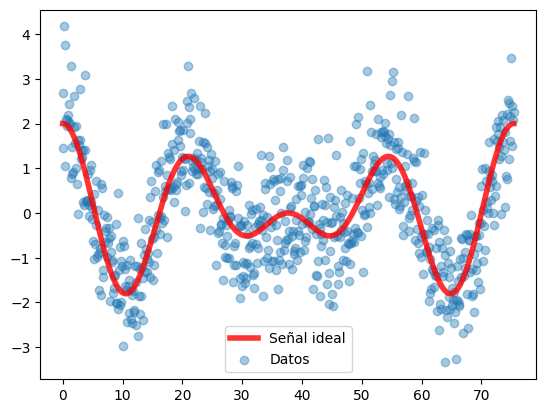

In [3]:
#Calcular la potencia de la señal verdadera:
P_signal = np.mean(tn_pura**2)

# Calcular la potencia del ruido (considerando SNR)
P_noise = P_signal / (10**(SNRdB / 10))

# Generar ruido blanco gaussiano
eta = np.random.normal(0, np.sqrt(P_noise), len(x_n))

#Señal pura + ruido
t_nr= tn_pura + eta

#graficamos la señal dada + la ruidosa

plt.plot(x_n,tn_pura,label='Señal ideal',c='r',linewidth=4, alpha=0.8)
plt.scatter(x_n,t_nr, alpha=0.4, label="Datos")
plt.legend()
plt.show()
#Graficamos la señal ideal y los datos:

# Datos de entrenamiento

In [4]:
# Dividir los datos en conjuntos de entrenamiento y prueba utilizando train_test_split.

X_train, X_test, t_train, t_test = train_test_split(x_n.reshape(-1,1), t_nr.reshape(-1,1),test_size=200/N, random_state=42)

print(X_train.shape,X_test.shape,t_train.shape,t_test.shape)

(500, 1) (200, 1) (500, 1) (200, 1)


# Mapeo $ \phi(\cdot)$

Para el entrenamiento y realizar el mapeo $ \phi(\cdot)$ del tipo polinomial de orden $Q$ se utilizó la libreria sklearn para facilitar la generación de las características.

In [5]:
# Mapeo de Representación polinomial desde la libreria sklearn, para entrenamiento

# Definir el grado del polinomio
Q = 25

# Crear un objeto PolynomialFeatures para generar características polinomiales hasta el grado especificado
phiQ = PolynomialFeatures(degree=Q)

# Representar los datos de entrenamiento como un polinomio de grado Q
Phi = phiQ.fit_transform(X_train)

# Escalar los datos utilizando MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Phi)
Phi = scaler.transform(Phi)

# Asegurar que la primera columna de Phi sea 1 para el término de sesgo del modelo
Phi[:, 0] = 1  # Como da una columna de 0, se cambia por columna de 1 para poder calcular la inversa y preservar la estabilidad computacional


# Maxima Verosimilitud

Obtenidos los pesos en el punto 2.1, se tiene que :

$W_{ML}=t_{n}^{T} \phi\left (  \phi ^{T}\phi \right )^{-1}$



In [ ]:
#Máxima Verosimilitud 
W_ml= t_train.T@Phi@(np.linalg.inv(Phi.T@Phi)) #Calcular los pesos del modelo por ML 

# Predict

In [ ]:
def max_ver(X, W):
    """
    Calcula la predicción utilizando el modelo de regresión lineal
    con la máxima verosimilitud.

    Parámetros:
        - X: Conjunto de datos de entrada.
        - W: Parámetros del modelo de regresión.

    Retorna:
        - y: Predicción del modelo para el conjunto de datos X.
    """

    # Determinar el grado del polinomio utilizado en el modelo
    Q = W.shape[1] - 1

    # Representar los datos de entrada como un polinomio de grado Q
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Normalizar los datos utilizando el mismo escalador que se utilizó durante el entrenamiento
    Phi = scaler.transform(Phi)

    # Agregar una columna de unos al principio de la matriz Phi
    # Esto es necesario para calcular el término de sesgo del modelo
    Phi[:, 0] = 1

    # Calcular la predicción utilizando los parámetros del modelo
    y = Phi @ W.T

    return y


In [ ]:
t_predictML= max_ver( X_test,W_ml) #Predicción de ML 

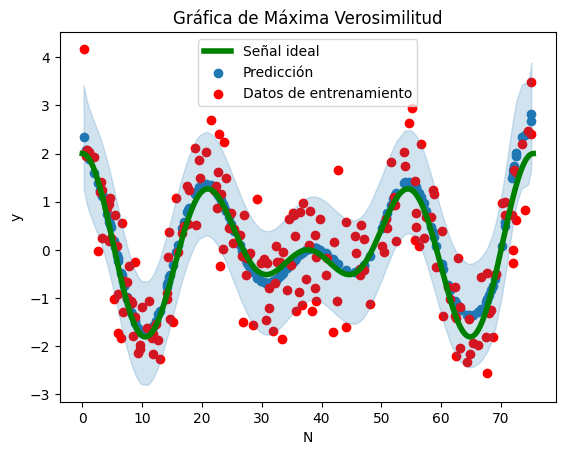

In [88]:
# Graficar la señal verdadera (valores reales)
plt.plot(x_n, tn_pura, label="Señal ideal", color="green", linewidth=4)

# Graficar la predicción del modelo de Maxima Verosimilitud
plt.scatter(X_test, t_predictML, label="Predicción")

# Graficar los datos de entrenamiento
plt.scatter(X_test, t_test, color="r", label="Datos de entrenamiento")

plt.fill_between(X_test[np.argsort(X_test.ravel())].ravel(), 
                 t_predictML[np.argsort(X_test.ravel())].ravel() - np.var(t_predictML),
                 t_predictML[np.argsort(X_test.ravel())].ravel() + np.var(t_predictML), 
                 color='C0', alpha=0.2)

# Agregar etiquetas y leyenda
plt.xlabel('N')
plt.ylabel('y')
plt.title('Gráfica de Máxima Verosimilitud')
plt.legend()

# Mostrar la gráfica
plt.show()


In [10]:
mae = mean_absolute_error(t_test, t_predictML) #calculo del error absoluto, respecto a los datos de testeo y la predición en dichos datos.
mae

0.6014419464004982

# Máximo Aposteriori

Obtenidos los pesos en el punto 2.1, se tiene que para MAP :

$W_{MAP}=t_{n}^{T} \phi\left (  \phi ^{T}\phi+\lambda I \right )^{-1}$ siendo :
$\lambda= \frac{\sigma ^{2}_{\eta }}{\sigma ^{2}_{\omega}}$

In [21]:
Lambda = P_noise / P_signal #Priori dado por la varianza del ruido y de los pesos.
Lambda 

0.6309573444801932

In [79]:
W_map= t_train.T@Phi@(np.linalg.inv(Phi.T@Phi+Lambda)) #Pesos de MAP
W_map

array([[ 2.60895655e+00, -7.83702044e+01,  2.42550179e+03,
        -4.76990560e+04,  4.32933203e+05, -1.97812400e+06,
         4.62929388e+06, -4.42622394e+06, -2.12211453e+06,
         7.42290625e+06, -3.25841822e+06, -2.47368942e+06,
         5.62878975e+06, -9.17353500e+06,  2.93244031e+06,
         6.35530188e+06, -3.17851031e+06,  7.69724688e+05,
         1.75270769e+06, -7.50982614e+06, -7.20770156e+05,
         4.66250381e+06,  6.72788959e+06, -7.03790728e+06,
        -8.17888688e+05,  1.42786761e+06]])

In [24]:
def max_apos(X, W):
    """
    Calcula la predicción utilizando el modelo de regresión lineal
    con la máxima a posteriori (MAP).

    Parámetros:
        - X: Conjunto de datos de entrada.
        - W: Parámetros del modelo de regresión (pesos).

    Retorna:
        - y: Predicción del modelo para el conjunto de datos X.
    """

    # Determinar el grado del polinomio utilizado en el modelo
    Q = W.shape[1] - 1

    # Representar los datos de entrada como un polinomio de grado Q
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Normalizar los datos utilizando el mismo escalador que se utilizó durante el entrenamiento
    Phi = scaler.transform(Phi)

    # Agregar una columna de unos al principio de la matriz Phi
    # Esto es necesario para calcular el término de sesgo del modelo
    Phi[:, 0] = 1

    # Calcular la predicción utilizando los parámetros del modelo
    y = Phi @ W.T

    return y


In [25]:
t_predictMAP= max_apos( X_test,W_map) #predicción de MAP 

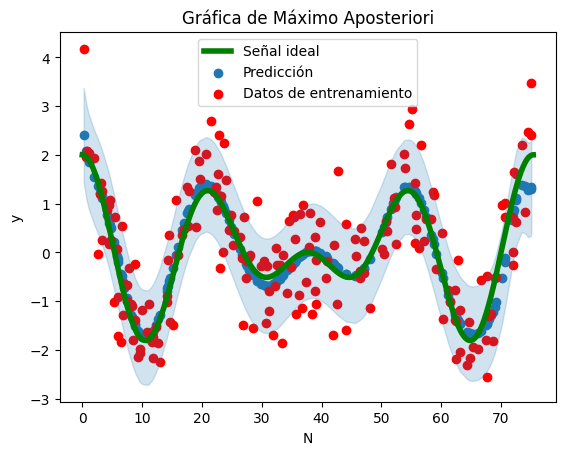

In [89]:
import matplotlib.pyplot as plt

# Graficar la señal verdadera (valores reales)
plt.plot(x_n, tn_pura, label="Señal ideal", color="green", linewidth=4)

# Graficar la predicción del modelo bayesiano
plt.scatter(X_test, t_predictMAP, label="Predicción")

# Graficar los datos de entrenamiento
plt.scatter(X_test, t_test, color="r", label="Datos de entrenamiento")

# Agregar etiquetas y leyenda
plt.fill_between(X_test[np.argsort(X_test.ravel())].ravel(), 
                 t_predictMAP[np.argsort(X_test.ravel())].ravel() - np.var(t_predictMAP),
                 t_predictMAP[np.argsort(X_test.ravel())].ravel() + np.var(t_predictMAP), 
                 color='C0', alpha=0.2)
plt.xlabel('N')
plt.ylabel('y')
plt.title('Gráfica de Máximo Aposteriori')
plt.legend()

# Mostrar la gráfica
plt.show()

In [27]:
mae = mean_absolute_error(t_test, t_predictMAP) #calculo del error absoluto, respecto a los datos de testeo y la predición en dichos datos.
mae

0.6037903569394217